In [ ]:
# Q1 Initialize a Spark session + load Datasets
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


df_edges = spark.read.csv("/edges.csv", header=True, inferSchema=True)
df_nodes = spark.read.csv("/nodes.csv", header=True, inferSchema=True)

In [ ]:
# Exploratory data analysis (EDA)
df_nodes.printSchema()

root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- chart_hits: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
# Converting followers from string to numeric value
df_nodes = df_nodes.withColumn("followers", col("followers").cast(IntegerType()))


In [ ]:
# Finding Average for Feature followers / popularity
df_nodes.selectExpr("avg(followers)", "avg(popularity)").show()


+-----------------+------------------+
|   avg(followers)|   avg(popularity)|
+-----------------+------------------+
|86224.26419762558|21.157497027272377|
+-----------------+------------------+



In [ ]:
# Followers / Popularity Distribution Summary
df_nodes.select("followers", "popularity").describe().show()


+-------+-----------------+------------------+
|summary|        followers|        popularity|
+-------+-----------------+------------------+
|  count|           156417|            156422|
|   mean|86224.26419762558|21.157497027272377|
| stddev| 940103.106174187|18.338289529604182|
|    min|                0|               0.0|
|    max|        102156853|             100.0|
+-------+-----------------+------------------+



In [ ]:
from pyspark.sql.functions import col, sum

# Counting nulls per column in df_nodes
df_nodes.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_nodes.columns]).show()


+----------+----+---------+----------+------+----------+
|spotify_id|name|followers|popularity|genres|chart_hits|
+----------+----+---------+----------+------+----------+
|         0|   0|        5|         0|     0|    136724|
+----------+----+---------+----------+------+----------+



In [ ]:
# Counting nulls per column in df_edges
df_edges.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_edges.columns]).show()


+----+----+
|id_0|id_1|
+----+----+
|   0|   0|
+----+----+



In [ ]:
#Q2 Create the Graph using NetworkX
import networkx as nx
all_edges = df_edges.select("id_0", "id_1").collect()
G_full = nx.Graph()
G_full.add_edges_from([(row.id_0, row.id_1) for row in all_edges])

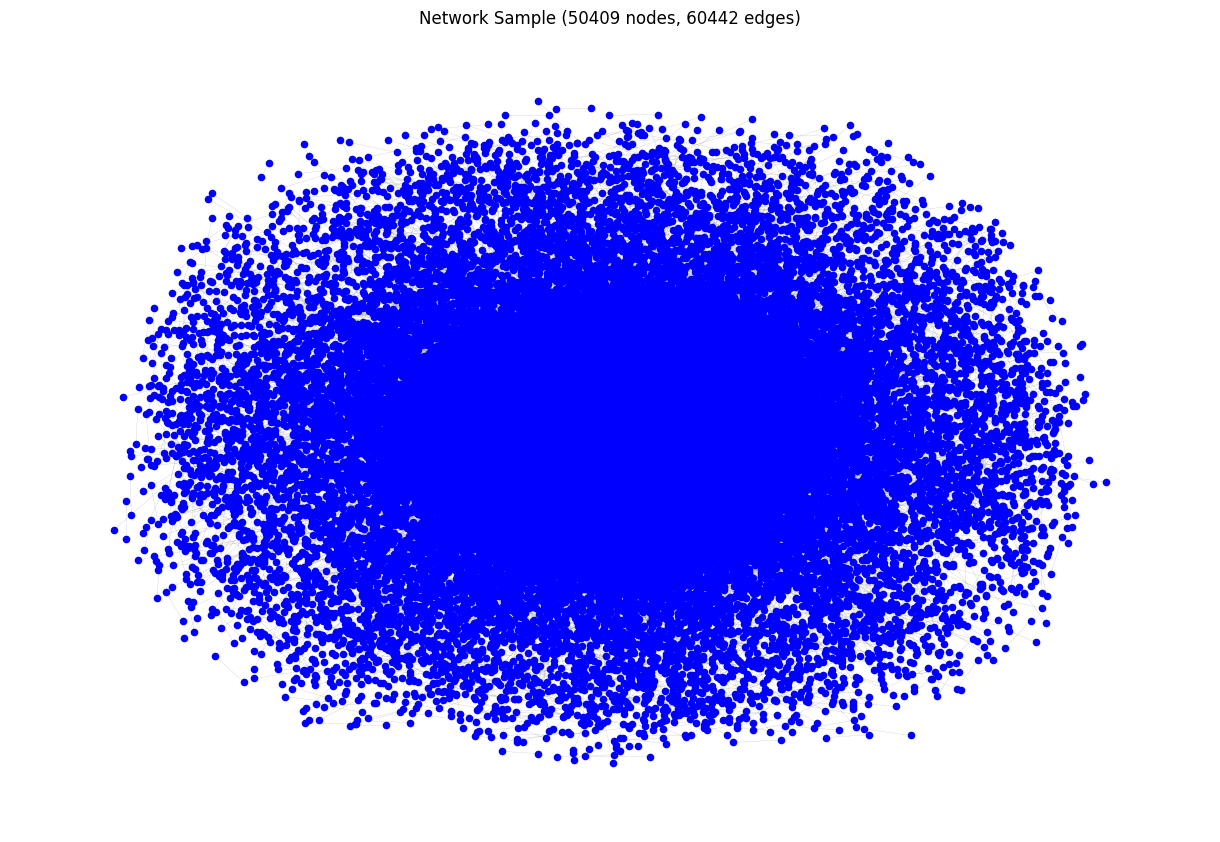

In [ ]:
#Q3 Visualizing a subset using NetworkX
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand


sample_fraction = 0.20
sampled_edges = df_edges.sample(withReplacement=False, fraction=sample_fraction, seed=42)


G = nx.Graph()
edges = sampled_edges.select("id_0", "id_1").collect()
G.add_edges_from([(row.id_0, row.id_1) for row in edges])


plt.figure(figsize=(12, 8))
nx.draw(G,
       node_size=20,
       node_color='blue',
       edge_color='gray',
       width=0.1,
       with_labels=False)
plt.title(f"Network Sample ({len(G.nodes())} nodes, {len(G.edges())} edges)")
plt.show()

In [ ]:
# Comparsion of full and smapled data
print("Full Graph:")
print("Nodes:", G_full.number_of_nodes())
print("Edges:", G_full.number_of_edges())
print("Average degree:", __builtin__.sum(dict(G_full.degree()).values()) / G_full.number_of_nodes())

print("\nSampled Graph:")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Average degree:", __builtin__.sum(dict(G.degree()).values()) / G.number_of_nodes())

Full Graph:
Nodes: 153327
Edges: 300386
Average degree: 3.9182401012215724

Sampled Graph:
Nodes: 50409
Edges: 60442
Average degree: 2.398063837806741


In [ ]:
#Q4 Compute Network Properties

 #Compute diameter
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

diameter_sampled = nx.diameter(G)
print("Network diameter of Sample Graph:", diameter_sampled)

Network diameter of Sample Graph: 37


In [ ]:
# Connected Components
num_components_full = nx.number_connected_components(G_full)
print("Number of connected compnents full graph: ", num_components_full)

num_components = nx.number_connected_components(G)
print("Number of connected compnents sample graph: ", num_components)

Number of connected compnents full graph:  1339
Number of connected compnents sample graph:  1


In [ ]:
# Network Density.
print("Full Graph:: ", nx.density(G_full))
print("Sampled Graph:: ", nx.density(G))

Full Graph::  2.555496198440951e-05
Sampled Graph::  6.713391834840804e-05


In [77]:
# Degree Centrality of nodes from sample graph
degree_centrality = nx.degree_centrality(G)

for node, centrality in degree_centrality.items():
    print(f"Node {node}: Degree Centrality = {centrality:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Betweenness Centrality of nodes from sample graph
betweenness_centrality = nx.centrality.betweenness_centrality(G)

for node, centrality in betweenness_centrality.items():
    print(f"Node {node}: Betweenness Centrality = {centrality:.4f}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Closeness Centrality of nodes from sample graph
closeness_centrality = nx.centrality.closeness_centrality(G)

for node, centrality in closeness_centrality.items():
    print(f"Node {node}: Closeness Centrality = {centrality:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Eigenvector Centrality of nodes from sample graph
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)

for node, centrality in eigenvector_centrality.items():
    print(f"Node {node}: Eigenvector Centrality = {centrality:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# PageRank of nodes from sample graph
pagerank_scores = nx.pagerank(G, alpha=0.85)

for node, score in pagerank_scores.items():
    print(f"Node {node}: PageRank = {score:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Adding/merging centrality scores to nodes.csv
import pandas as pd


centrality_pd = pd.DataFrame({
    'spotify_id': list(degree_centrality.keys()),
    'degree': list(degree_centrality.values()),
    'betweenness': list(betweenness_centrality.values()),
    'closeness': list(closeness_centrality.values()),
    'eigenvector': list(eigenvector_centrality.values()),
    'pagerank': list(pagerank_scores.values())
})

df_centrality = spark.createDataFrame(centrality_pd)


In [ ]:
#Merging the dataframes
df_merged = df_centrality.join(df_nodes, on="spotify_id", how="inner")


In [ ]:
# Check for missing values in each column of df_merged
df_merged.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_merged.columns]).show()


+----------+------+-----------+---------+-----------+--------+----+---------+----------+------+----------+
|spotify_id|degree|betweenness|closeness|eigenvector|pagerank|name|followers|popularity|genres|chart_hits|
+----------+------+-----------+---------+-----------+--------+----+---------+----------+------+----------+
|         0|     0|          0|        0|          0|       0|   0|        1|         0|     0|     37558|
+----------+------+-----------+---------+-----------+--------+----+---------+----------+------+----------+



In [ ]:
df_merged = df_merged.dropna()

In [ ]:
df_merged.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_merged.columns]).show()

+----------+------+-----------+---------+-----------+--------+----+---------+----------+------+----------+
|spotify_id|degree|betweenness|closeness|eigenvector|pagerank|name|followers|popularity|genres|chart_hits|
+----------+------+-----------+---------+-----------+--------+----+---------+----------+------+----------+
|         0|     0|          0|        0|          0|       0|   0|        0|         0|     0|         0|
+----------+------+-----------+---------+-----------+--------+----+---------+----------+------+----------+



In [ ]:
#printing top 5 of each centrality measure
print("Top 5 by Degree Centrality:")
df_merged.select("name", "degree").orderBy(col("degree").desc()).show(5, truncate=False)

print("Top 5 by Betweenness Centrality:")
df_merged.select("name", "betweenness").orderBy(col("betweenness").desc()).show(5, truncate=False)

print("Top 5 by Closeness Centrality:")
df_merged.select("name", "closeness").orderBy(col("closeness").desc()).show(5, truncate=False)

print("Top 5 by Eigenvector Centrality:")
df_merged.select("name", "eigenvector").orderBy(col("eigenvector").desc()).show(5, truncate=False)

print(" Top 5 by PageRank:")
df_merged.select("name", "pagerank").orderBy(col("pagerank").desc()).show(5, truncate=False)


Top 5 by Degree Centrality:
+---------------------+---------------------+
|name                 |degree               |
+---------------------+---------------------+
|Johann Sebastian Bach|0.007816219647674972 |
|Traditional          |0.005772893191556896 |
|Mc Gw                |0.003749404856372004 |
|MC MN                |0.0025392794794477066|
|Jean Sibelius        |0.0023805745119822247|
+---------------------+---------------------+
only showing top 5 rows

Top 5 by Betweenness Centrality:
+----------+--------------------+
|name      |betweenness         |
+----------+--------------------+
|R3HAB     |0.041880668963641746|
|Steve Aoki|0.031087305574665408|
|Tiësto    |0.028382177511621337|
|Snoop Dogg|0.02086714173375113 |
|Diplo     |0.020509469994581954|
+----------+--------------------+
only showing top 5 rows

Top 5 by Closeness Centrality:
+------------+-------------------+
|name        |closeness          |
+------------+-------------------+
|R3HAB       |0.1497348148999924 

In [ ]:
#Q5 Linear Regression model
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

# Features for regression
feature_cols = ['followers', 'degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']

# Using VectorAssembler to combine features
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform while preserving popularity
df_prepared = assembler.transform(df_merged)

# Then select only the needed columns
df_prepared = df_prepared.select("features", "popularity")


In [ ]:
#Spliting the dataset
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)


# Training the linear regression model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='popularity')
lr_model = lr.fit(train_data)

# Model Coefficients and Intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Coefficients: [1.2987970488834224e-06,67592.54968982446,-651.4138790417807,89.31951115605288,-201.19294279217894,-157231.84607384255]
Intercept: 39.7308272709186


In [ ]:
# Training / Testing count
print("Training set size:", train_data.count())
print("Testing set size:", test_data.count())


Training set size: 10422
Testing set size: 2504


In [ ]:
# LR Model Evaluation
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol='popularity', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='popularity', predictionCol='prediction', metricName='r2')

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE): ",rmse)
print("R² (Coefficient of Determination): ", r2)


Root Mean Squared Error (RMSE):  13.200432117421943
R² (Coefficient of Determination):  0.285166564865991


In [ ]:
#Q 6 K-means Clustering

# Standardize the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_prepared)
df_scaled = scaler_model.transform(df_prepared)




In [ ]:
# fitting the k-means model
from pyspark.ml.clustering import KMeans

k = 6
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=k, seed=42)
kmeans_model = kmeans.fit(df_scaled)
df_clusters = kmeans_model.transform(df_scaled)


In [ ]:
# Number  of users in each cluster
df_clusters.groupBy("cluster").count().orderBy("cluster").show()


+-------+-----+
|cluster|count|
+-------+-----+
|      0| 3921|
|      1|    1|
|      2| 1243|
|      3|   61|
|      4|   39|
|      5| 7661|
+-------+-----+



In [ ]:
# k-means evaluation
wssse = kmeans_model.summary.trainingCost
print("Within Set Sum of Squared Errors (WSSSE): ",wssse)



Within Set Sum of Squared Errors (WSSSE):  19399.294214186877


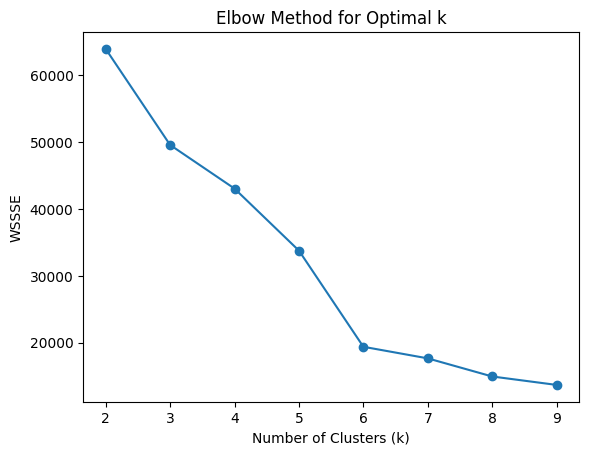

In [ ]:
# Find the Optimal Number of Clusters
cost = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    cost.append((k, model.summary.trainingCost))


ks, errors = zip(*cost)
plt.plot(ks, errors, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE')
plt.title('Elbow Method for Optimal k')
plt.show()
